In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
'My Drive'


In [ ]:
### Set the right directory
%cd /gdrive/My\ Drive/Colab\ Notebooks/RL/citylearn/CityLearn

/gdrive/My Drive/Colab Notebooks/RL/citylearn/CityLearn


In [ ]:
import os
import gym
import numpy as np
from stable_baselines import SAC
from stable_baselines.sac.policies import MlpPolicy as MlpPolicy_SAC
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import time
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_3']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = None)
env = Monitor(env, log_dir)

In [ ]:
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=8760, log_dir=log_dir)
model.learn(total_timesteps=8760*10, log_interval=1000)
print(time.time()-start)

obs = env.reset()
dones = False
counter = []
while dones==False:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    counter.append(rewards)
env.cost()





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Cumulated reward: -156219.77319999892
Cumulated reward: -152927.11109999975
Cumulated reward: -152840.80239999978
Cumulated reward: -152826.26519999967
Cumulated reward: -152829.52599999963
Cumulated reward: -152851.36829999986
Cumulated reward: -152803.4323999998
Cumulated reward: -152850.46509999974
Cumulated reward: -152837.26639999976
Cumulated reward: -152791.5493999998
1398.312518119812
Cumulated reward: -152848.1041999997


{'1-load_factor': 1.193520513763172,
 'average_daily_peak': 1.4081185,
 'net_electricity_consumption': 1.053519,
 'peak_demand': 1.2713071,
 'quadratic': 1.587607,
 'ramping': 1.0594561,
 'total': 1.2622547095997703}

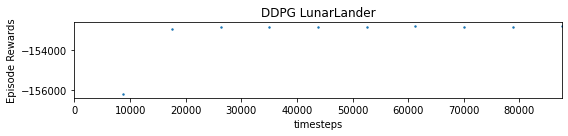

In [ ]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 8760*10, results_plotter.X_TIMESTEPS, "DDPG LunarLander")

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_3']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = 2)
env = Monitor(env, log_dir)

In [ ]:
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=8760, log_dir=log_dir)
model.learn(total_timesteps=8760*10, log_interval=1000)
print(time.time()-start)

obs = env.reset()
dones = False
counter = []
while dones==False:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    counter.append(rewards)
env.cost()

Cumulated reward: -7515285.212021485
Cumulated reward: -6316434.41440223
Cumulated reward: -6308695.376324098
Cumulated reward: -6293163.288224224
Cumulated reward: -6294425.892485576
Cumulated reward: -5852204.8539673835
Cumulated reward: -5461183.162068231
Cumulated reward: -5413335.960384945
Cumulated reward: -5296381.041988203
Cumulated reward: -5244715.250097152
1393.9128015041351
Cumulated reward: -5125073.269051348


{'1-load_factor': 1.2532310834911908,
 'average_daily_peak': 1.4159402,
 'net_electricity_consumption': 0.9884717,
 'peak_demand': 1.2835494,
 'quadratic': 1.2828104,
 'ramping': 2.188872,
 'total': 1.402145818726676}

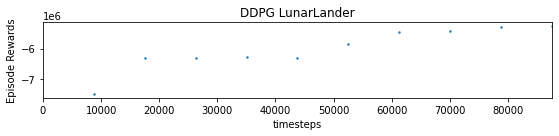

In [ ]:
results_plotter.plot_results([log_dir], 8760*10, results_plotter.X_TIMESTEPS, "DDPG LunarLander")

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
# Central agent controlling one of the buildings using the OpenAI Stable Baselines
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ['Building_3']
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, \
                building_ids, buildings_states_actions = building_state_actions,\
                cost_function = objective_function, central_agent = True, \
                verbose = 1, reward = 3)
env = Monitor(env, log_dir)

In [ ]:
model = SAC(MlpPolicy_SAC, env, verbose=0, learning_rate=0.01, gamma=0.99, tau=3e-4, batch_size=2048, learning_starts=8759)
start = time.time()
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=8760, log_dir=log_dir)
model.learn(total_timesteps=8760*10, log_interval=1000)
print(time.time()-start)

obs = env.reset()
dones = False
counter = []
while dones==False:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    counter.append(rewards)
env.cost()

Cumulated reward: -514476637.62025875
Cumulated reward: -373514121.0376429
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
Cumulated reward: -374101933.5055459
1419.0518987178802
Cumulated reward: -374101933.5055459


{'1-load_factor': 1.2039918410770736,
 'average_daily_peak': 1.4510968,
 'net_electricity_consumption': 1.1020107,
 'peak_demand': 1.2767103,
 'quadratic': 1.6764889,
 'ramping': 1.0719012,
 'total': 1.2970332819222186}

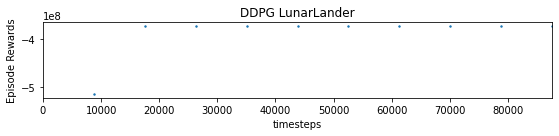

In [ ]:
results_plotter.plot_results([log_dir], 8760*10, results_plotter.X_TIMESTEPS, "DDPG LunarLander")